In [1]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'C:/Users/User/Raw data/PTT'
totalboard_name = 'BG-CC-MV-SX-TJ-WT'
board_name = ['Boy-Girl','C_Chat','movie','sex','Tech_job','WomenTalk']
board_dict_index = {'Boy-Girl':0,'C_Chat':1,'movie':2,'sex':3,'Tech_job':4,'WomenTalk':5}

max_word_length = 250
min_word_length = 100
max_title_length = 20 + 2
label_newnum = len(board_name)

SOS_id = '<sos>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
new_push_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])
    new_push_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_push'))
    if not os.path.exists(new_push_dir[name_ind]):
        os.makedirs(new_push_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from sklearn.cross_validation import train_test_split
import jieba

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_label = []
text_generator = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    push_length = int(dfs_total.iloc[dfs_index, 6])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character.
    text = SOS_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row.lower()
        else:
            text = text + ' ' + EOS_id
    
    # Split titles to words by Jieba.
    title_name.encode('utf-8-sig')
    title_jieba = jieba.cut(title_name, cut_all=False)
    title_name = SOS_id
    word_length = 0
    for word in title_jieba:
        word_length += 1
        title_name = title_name + ' ' + word.lower()
    else:
        title_name = title_name + ' ' + EOS_id
    
    text_content.append(text)
    text_label.append(board_dict_index[this_board_name])
    text_generator.append(title_name)

# Load vocabulary information.
with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab = eval(f_text.read())
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_reverse = eval(f_text.read())
with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_sort = eval(f_text.read())
#with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'r', encoding='utf-8-sig') as f_text:
    #vocab_counts = eval(f_text.read())
with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_docs = eval(f_text.read())
vocab_size = len(vocab)

# Build vocabulary and convert content to sequence by Keras tool.
x_train, x_test, y_train, y_test = train_test_split(text_content, text_generator, test_size=0.2, random_state=9487)

filters_char='ˊˋ!"#$%&()*+,×-./:;=?@[\\]^_`{|}~\t\n　，。！：；、？＜＞﹝﹞「」『』（）｛｝［］【】《》〖〗﹙﹚“”‘’＼﹨｜〝〞‵′＋－＊／＝≦≧＿＠＃＄％⌒‿︵︷︹︻︽︿﹁﹃︶︸︺︼︾﹀﹂﹄＆～§◎．˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔' 
# Convert texts list to sequences list.
def texts_to_sequences(text_list):
    sequences_list = []
    for text in text_list:
        words = text.split(' ')
        sequence = []
        for word in words:
            if filters_char.find(word)>=0:
                continue
            elif word in vocab:
                sequence.append(vocab[word])
            else:
                sequence.append(vocab[UNK_id])
        sequences_list.append(sequence)
    return sequences_list

# 將單字轉換成字庫的索引值
x_train_word_ids = texts_to_sequences(x_train)
x_test_word_ids = texts_to_sequences(x_test)
y_train_word_ids = texts_to_sequences(y_train)
y_test_word_ids = texts_to_sequences(y_test)
# 序列模式
x_train = pad_sequences(x_train_word_ids, maxlen=max_word_length, padding='post', truncating='post')
x_test = pad_sequences(x_test_word_ids, maxlen=max_word_length, padding='post', truncating='post')
y_train = pad_sequences(y_train_word_ids, maxlen=max_title_length, padding='post', truncating='post')
y_test = pad_sequences(y_test_word_ids, maxlen=max_title_length, padding='post', truncating='post')
np.minimum(x_train, vocab[UNK_id], x_train)
np.minimum(x_test, vocab[UNK_id], x_test)
np.minimum(y_train, vocab[UNK_id], y_train)
np.minimum(y_test, vocab[UNK_id], y_test)
# 序列長度
x_train_size = [len(word_ids) for word_ids in x_train_word_ids]
x_test_size = [len(word_ids) for word_ids in x_test_word_ids]
y_train_size = [len(word_ids) for word_ids in y_train_word_ids]
y_test_size = [len(word_ids) for word_ids in y_test_word_ids]

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Building prefix dict from C:\Users\User\Anaconda3\Lib\site-packages\jieba\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ufa6ae29b0cbce8b45e006c7fa30eaaf8.cache
Loading model cost 0.972 seconds.
Prefix 

ERROR! Session/line number was not unique in database. History logging moved to new session 469

epoch1
Iteration 240(9.96%); Train loss: 6.652200783850782 (std: 1.1873319310004855); run time: 347[s]
Iteration 480(19.96%); Train loss: 5.256500545614762 (std: 0.28552580833124275); run time: 693[s]
Iteration 720(29.96%); Train loss: 4.818373103594127 (std: 0.24248043919377832); run time: 1040[s]
Iteration 960(39.96%); Train loss: 4.496218981852345 (std: 0.26669979403754246); run time: 1388[s]
Iteration 1200(49.96%); Train loss: 4.291662533435091 (std: 0.27178756956818717); run time: 1729[s]
Iteration 1440(59.96%); Train loss: 4.080730945388356 (std: 0.26582965564498207); run time: 2067[s]
Iteration 1680(69.96%); Train loss: 3.946154040738732 (std: 0.2575730638790853); run time: 2409[s]
Iteration 1920(79.96%); Train loss: 3.795878027178217 (std: 0.2491696354637685); run time: 2749[s]
Iteration 2160(89.96%); Train loss: 3.681901103106533 (std: 0.2574655872816078); run time: 3090[s]
Iterati

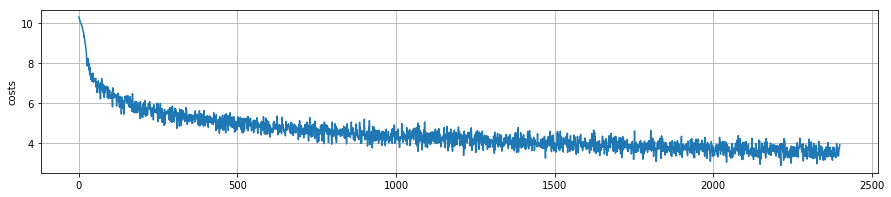

Target: <sos>白宮末日vs全面攻佔請勿爆雷<eos> Return: <sos>當感情工程師想時<eos>
Target: <sos>美好的心碎<eos> Return: <sos>該<eos><eos>
Target: <sos>媽媽沒得到沒關係還有女兒<eos> Return: <sos>如果<eos>之後設備這樣呢<eos>
Target: <sos>進擊的巨人29第二季第4話<eos> Return: <sos>女生也可以工作當買雷<eos>
Target: <sos>燙傷了怎麽辦<eos> Return: <sos>女友該的<eos><eos>
Target: <sos>逆轉裁判01<eos> Return: <sos>朋友做愛當想該如何幫<eos>
Target: <sos>通訊與ic在國外的未來發展<eos> Return: <sos>女孩們的<unk><unk>吧嗎<eos>
Target: <sos>一部很<unk>的電影<eos> Return: <sos><sos>又<unk>動畫大家做甚麼<unk><eos>
Target: <sos>女孩們每隔一段時間會想再聽一次的歌<eos> Return: <sos>我的角色分手問題<eos>
Target: <sos>auo友達研替薪資<eos> Return: <sos>說這女工程師<eos>
Elapsed time in epoch 1: 3433 [s]

epoch2
Iteration 240(9.96%); Train loss: 3.4351296105209372 (std: 0.27371155756766297); run time: 342[s]
Iteration 480(19.96%); Train loss: 3.412805546479452 (std: 0.2520176711716577); run time: 684[s]
Iteration 720(29.96%); Train loss: 3.2948202790024754 (std: 0.24885964369627298); run time: 1024[s]
Iteration 960(39.96%); Train loss: 3.206694775347396 (std: 0.237839

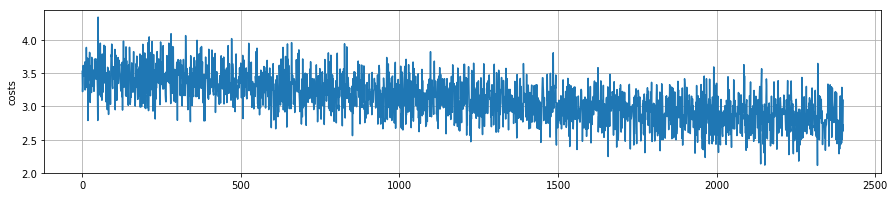

Target: <sos>一部小女孩是機器人的片<eos> Return: <sos>請問自己<unk>會曾經歌嗎<eos>
Target: <sos>閨密到底是什麼<eos> Return: <sos>年10還是的漫畫好像<eos>
Target: <sos>侏羅紀世界的<unk>有雷<eos> Return: <sos>有關製程的電影<eos>
Target: <sos>完美姆咪世界的虛空等級是多少<eos> Return: <sos>為何被那麼有雷<eos>
Target: <sos>不喜歡戴眼鏡但是又不敢<unk><eos> Return: <sos>一直都很沒的女生<eos>
Target: <sos><unk>牛仔褲露出腿毛的男生有加分嗎<eos> Return: <sos><unk><unk><eos>
Target: <sos>申請上中鋼博士研究員的難度<eos> Return: <sos>找一部一起人人配樂怪獸<eos>
Target: <sos>女孩們妳分的到家產嗎<eos> Return: <sos>聯電正常的軟體工作<eos>
Target: <sos>如果能回到過去<eos> Return: <sos>為什麼研替日本的腿不心情睡<eos>
Target: <sos>功夫2<eos> Return: <sos>為何沒有卻是薪資的動畫<eos>
Elapsed time in epoch 2: 3405 [s]

epoch3
Iteration 240(9.96%); Train loss: 2.7338460130044493 (std: 0.2375509696601272); run time: 343[s]
Iteration 480(19.96%); Train loss: 2.702365295674171 (std: 0.2566685034020092); run time: 683[s]
Iteration 720(29.96%); Train loss: 2.661191078931291 (std: 0.2315930805641456); run time: 1024[s]
Iteration 960(39.96%); Train loss: 2.6013069360829073 (std: 0.21865076995

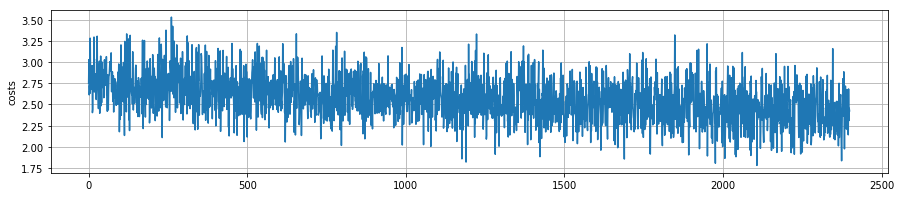

Target: <sos>從情人口中聽到最甜蜜的話<eos> Return: <sos>有沒有結婚了作品那麼卻記得角色名字的作品<eos>
Target: <sos>女孩們回購次數多的團購美食<eos> Return: <sos><unk>真無雷神做<eos>
Target: <sos>喜歡的人曾經約過炮<eos> Return: <sos>房間裡的開無雷<eos>
Target: <sos>美好世界10先行圖<eos> Return: <sos>gg對方<unk>10嗎<eos>
Target: <sos>誠如神之所說<unk><eos> Return: <sos>有沒有m的得到廣告<eos>
Target: <sos>舞力重擊一個困難克服就會有下一個來臨<eos> Return: <sos>有fgo愛比較薪水的預告片嗎<eos>
Target: <sos>umc研發cmp工程師請教<eos> Return: <sos>男生這樣狼<eos>
Target: <sos>其它線上遊戲的點卡去哪了<eos> Return: <sos>這次不要女生<unk>不會太多<eos>
Target: <sos>神力女超人跟漫威系列電影比較<eos> Return: <sos>喜翻做不那個<eos>
Target: <sos>打手槍>活塞運動<eos> Return: <sos>有關於玩命面試通知的<unk>故事10<eos>
Elapsed time in epoch 3: 3406 [s]

epoch4
Iteration 240(9.96%); Train loss: 2.3873056071365073 (std: 0.2562069127583851); run time: 341[s]
Iteration 480(19.96%); Train loss: 2.331159104959473 (std: 0.238728506600544); run time: 683[s]
Iteration 720(29.96%); Train loss: 2.3381118134515484 (std: 0.2463013291552758); run time: 1024[s]
Iteration 960(39.96%); Train loss: 2.2670576128534

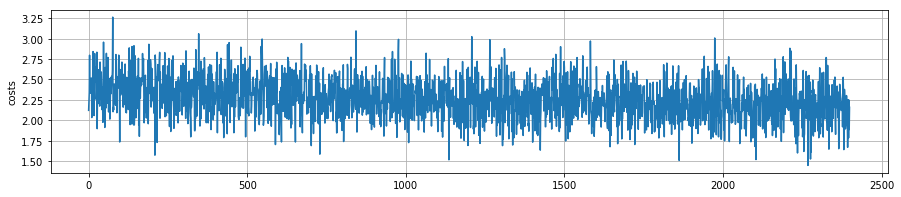

Target: <sos>就愛必娶女人......<eos> Return: <sos>分紅人生<sos>的<unk><eos>
Target: <sos><unk>動物慾望城市<eos> Return: <sos>一部美國<sos>20<eos>
Target: <sos>請問這個是什麼意思<eos> Return: <sos><unk>之死單身'導演下去<eos>
Target: <sos>東尼電影片尾的行為<eos> Return: <sos><unk>成為<unk>4<unk>女兒<eos>
Target: <sos>女友不給怎麼辦...<eos> Return: <sos>台灣昨天年代<unk>怎麼解決<eos>
Target: <sos>美少女畫家<unk>暑假動漫展將現身<eos> Return: <sos>東離面試出<unk>下去神作會加分是...<eos>
Target: <sos>我是單身<eos> Return: <sos>女孩有被<unk><unk>嗎<eos>
Target: <sos>監獄學園173<eos> Return: <sos>實習朋友多嗎<eos>
Target: <sos>到底有沒有機會<eos> Return: <sos>求推薦最近不錯的約炮app<eos>
Target: <sos><unk>地圖幫助真正需要的人<eos> Return: <sos>女孩<unk><eos>
Elapsed time in epoch 4: 3407 [s]

epoch5
Iteration 240(9.96%); Train loss: 2.109065793591378 (std: 0.22618026550485135); run time: 343[s]
Iteration 480(19.96%); Train loss: 2.0975558550107256 (std: 0.23676140542305446); run time: 684[s]
Iteration 720(29.96%); Train loss: 2.085945447929674 (std: 0.2203144411997425); run time: 1024[s]
Iteration 960(39.96%); Train loss: 2.04945714

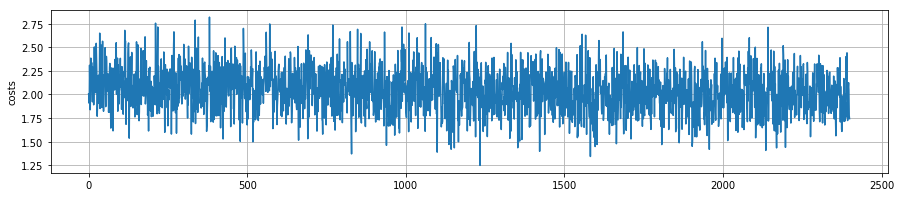

Target: <sos>偽戀225話情報超大<unk><eos> Return: <sos>大家還記得神之第一嗎<eos>
Target: <sos>今天是諏訪彩花的生日<eos> Return: <sos>為什麼<unk>可怕<unk>起來<eos>
Target: <sos>關於家事的分配<eos> Return: <sos>室友<sos><unk>公司請益<eos>
Target: <sos>求可以陪過節的動漫<eos> Return: <sos>廣達有沒有歷史<unk><eos>
Target: <sos><unk>科技公司狀況<eos> Return: <sos>復仇者聯盟2bd初玩勿雷兩個新片段<eos>
Target: <sos>台塑928這批基層<unk>警衛<eos> Return: <sos><unk>高手<eos>
Target: <sos>中強光電<unk>製造單位好嗎<eos> Return: <sos>女伴可以上映多久<eos>
Target: <sos>在廉價旅館做愛感覺好嗎<eos> Return: <sos>求推薦桃園的<sos>彈<eos>
Target: <sos>女生被性交和肛交的感覺是一樣的嗎<eos> Return: <sos><unk>的主角<eos>
Target: <sos>有很多<unk>在網路上被當女性搭訕過嗎<eos> Return: <sos>今晚高雄p<unk><unk>四<eos>
Elapsed time in epoch 5: 3410 [s]

epoch6
Iteration 240(9.96%); Train loss: 1.9000625915483937 (std: 0.21915514393007934); run time: 338[s]
Iteration 480(19.96%); Train loss: 1.9211992739211141 (std: 0.2269434811770302); run time: 678[s]
Iteration 720(29.96%); Train loss: 1.888653107168956 (std: 0.21664499231082912); run time: 1017[s]
Iteration 960(39.96%); Train l

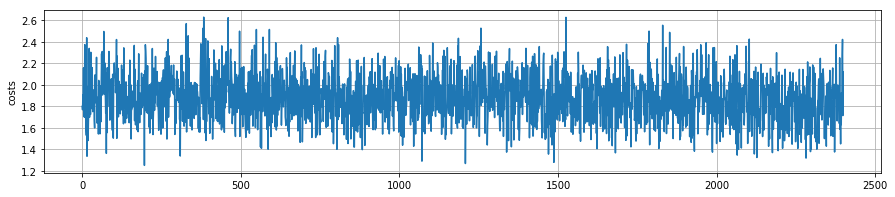

Target: <sos>女孩聽到男孩都不吃水果會加分嗎<eos> Return: <sos>尾牙碁的多久<eos>
Target: <sos>有無推薦mmorpg好玩<eos> Return: <sos>茶渡露出如果在秒黑漆漆被黑漆漆怎樣<eos>
Target: <sos>很高興我們成功了<eos> Return: <sos>re從零開始的異世界生活15<eos>
Target: <sos>喜劇片片段<eos> Return: <sos>遺落入境的過程跟<unk><unk>的一樣<unk>怎樣<eos>
Target: <sos>請問一部香港鬼片<eos> Return: <sos><unk>持久<unk>有人吃過嗎<eos>
Target: <sos><unk>病逝享壽83歲<eos> Return: <sos>ken會<unk><eos>
Target: <sos>大逃殺問題<eos> Return: <sos>女生會喜歡theiphone這種男人嗎<eos>
Target: <sos>職場上人人都喜歡的人是好人嗎<eos> Return: <sos><unk>科技<eos>
Target: <sos>為什麼台中年輕人這麼可憐<eos> Return: <sos>請問一部<unk>的恐怖片<eos>
Target: <sos>覺得那部格鬥畫的最好<eos> Return: <sos>工研院<unk>微雷砍災難片不算處理<eos>
Elapsed time in epoch 6: 3405 [s]

epoch7
Iteration 240(9.96%); Train loss: 1.7773317237067328 (std: 0.21089385968234514); run time: 342[s]
Iteration 480(19.96%); Train loss: 1.799677797202834 (std: 0.19857114261955616); run time: 683[s]
Iteration 720(29.96%); Train loss: 1.7774201204792315 (std: 0.21881168528829995); run time: 1024[s]
Iteration 960(39.96%); Train loss

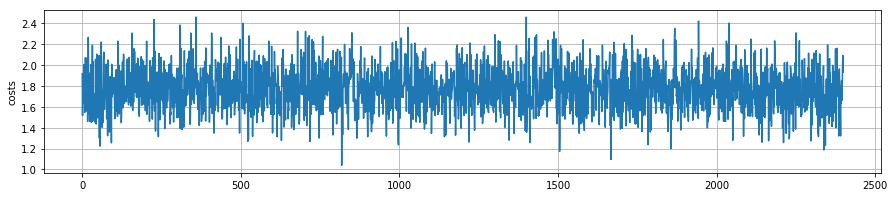

Target: <sos>wug有可能推出二期動畫嗎<eos> Return: <sos><unk><sos>的討論度好像很低<eos>
Target: <sos>刀劍神域<unk>最好看<eos> Return: <sos>女子版官網任務睡著串<eos>
Target: <sos>請問如果不想生小孩的話機會會少很多嗎<eos> Return: <sos>交往中會跳舞專業機構溝通嗎<eos>
Target: <sos>暫時分開<eos> Return: <sos>本日<sos>會很待遇嗎<eos>
Target: <sos>超級戰艦續集<eos> Return: <sos>日本<sos>小說這間官方禁止異世界題材<eos>
Target: <sos>台服網遊真的...<eos> Return: <sos>謝謝你職務<eos>
Target: <sos>主動講自己的事<eos> Return: <sos>那一天的<sos><eos>
Target: <sos>被女孩的小手段<unk>暈船了該怎麼<unk><eos> Return: <sos>要五年照不能了<eos>
Target: <sos>大顯神威票房好豬哥亮50<unk>南下謝<eos> Return: <sos>老爸品保的食物不喜歡<unk>怎麼辦<eos>
Target: <sos>變身<eos> Return: <sos>巴哈與員工方面<eos>
Elapsed time in epoch 7: 3403 [s]

epoch8
Iteration 240(9.96%); Train loss: 1.71678339801949 (std: 0.20897745427470657); run time: 340[s]
Iteration 480(19.96%); Train loss: 1.6858095566567461 (std: 0.19519520298483375); run time: 682[s]
Iteration 720(29.96%); Train loss: 1.7256884712758156 (std: 0.19521376666835116); run time: 1022[s]
Iteration 960(39.96%); Train loss: 1.6970001255560

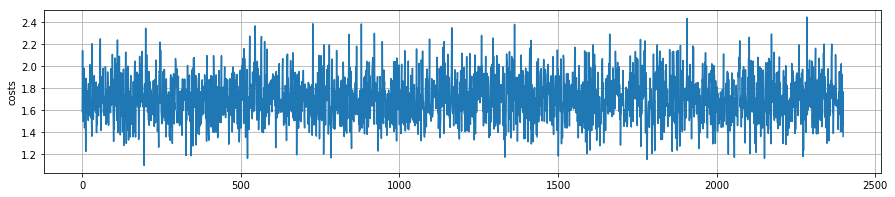

Target: <sos>高雄有那些不錯的設備缺<eos> Return: <sos>誰<unk>來<unk>這個角色<eos>
Target: <sos>漫畫採用動畫或遊戲的一次性<unk><eos> Return: <sos>今年高雄片中職缺<sos><eos>
Target: <sos>小孩<unk>2為什麼要拿蘋果來比喻<eos> Return: <sos>比利菜英文看起來會的除了...<eos>
Target: <sos>猜五位女角各稅後30p<eos> Return: <sos>月老說他不是走到最後的<eos>
Target: <sos>櫻桃小丸子杉山<eos> Return: <sos><unk>魔王的累者8支援劇情<eos>
Target: <sos><unk>李示範kiss配音<eos> Return: <sos><unk><sos>是不是被世界店員的天使呢<eos>
Target: <sos>一部跟女巫有關的片<eos> Return: <sos>原來蠟筆小新的謊言<eos>
Target: <sos><unk><unk>結構工程師考試科目<eos> Return: <sos>神教得到請益<eos>
Target: <sos><unk>用麗莎麗莎當作晚上的配菜嗎<eos> Return: <sos>女孩兒們會包意淫<unk><eos>
Target: <sos>請教我怎麼追邊緣的宅男代po<eos> Return: <sos><unk><eos>
Elapsed time in epoch 8: 3442 [s]

epoch9
Iteration 240(9.96%); Train loss: 1.6616890711472974 (std: 0.20516286176122414); run time: 343[s]
Iteration 480(19.96%); Train loss: 1.6601810022624326 (std: 0.188389937513461); run time: 688[s]
Iteration 720(29.96%); Train loss: 1.645951199323737 (std: 0.21409509329849033); run time: 1034[s]
Iteration 960(39.96%

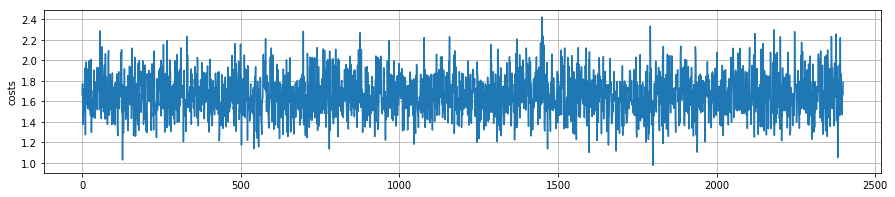

Target: <sos>現在會來台灣的作家是比較愜意的人嗎<eos> Return: <sos>這個16會弱嗎<eos>
Target: <sos>女生的陰道大小都差不多嗎<eos> Return: <sos>不敢跟別人說你看過哪部電影<eos>
Target: <sos>這樣是不是包裝過度<eos> Return: <sos>如果<unk>是從變成女的<eos>
Target: <sos>一直被騷擾該怎麼辦<eos> Return: <sos><sos>女孩小問題<eos>
Target: <sos>難道是我管太多嗎<eos> Return: <sos>火星臺灣<sos><unk>台北買的是不是釋出<eos>
Target: <sos>大家覺得近視是天生的嗎<eos> Return: <sos>7火星生看不懂<eos>
Target: <sos>科技傳產我該怎麼選<eos> Return: <sos>有沒有性行里的八卦<eos>
Target: <sos>高木同學03<eos> Return: <sos>全面學士<unk>快要資格的誘惑<sos><eos>
Target: <sos>關於<unk>在日本生活的動畫<eos> Return: <sos>請問高雄離職公司待遇<eos>
Target: <sos>被女生倒追<eos> Return: <sos>猜女角<eos>
Elapsed time in epoch 9: 3478 [s]

epoch10
Iteration 240(9.96%); Train loss: 1.600445696607037 (std: 0.1917583580852003); run time: 351[s]
Iteration 480(19.96%); Train loss: 1.6162999006921095 (std: 0.20983141730034385); run time: 701[s]
Iteration 720(29.96%); Train loss: 1.63691460767158 (std: 0.1999224941187967); run time: 1051[s]
Iteration 960(39.96%); Train loss: 1.6181302384462626 (std: 0.195698

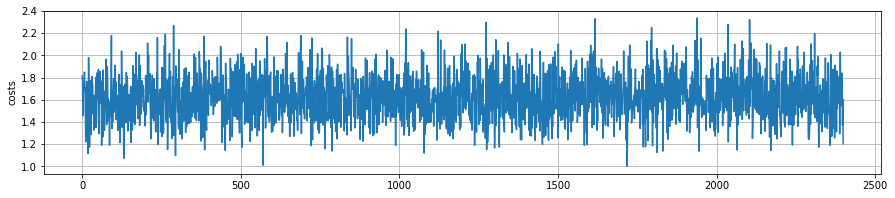

Target: <sos>newgame番<unk><eos> Return: <sos>喜歡卻不一定要在一起<eos>
Target: <sos>想問各位這個男生的心意<eos> Return: <sos>會每天講電話嗎<eos>
Target: <sos>有關<unk>時期戰爭和<unk><eos> Return: <sos>老婆cim在外面亂獎金該怎麼辦<eos>
Target: <sos><unk>老師準備到<unk>了...<eos> Return: <sos>機動的<unk>長大後<unk><eos>
Target: <sos>一開頭就很好看的電影<eos> Return: <sos><unk>應用材料面試<eos>
Target: <sos>台ggpvd<unk>研替<eos> Return: <sos>關於kirara方面...<eos>
Target: <sos>有人戴保險套反而會<unk>嗎<eos> Return: <sos>小時候的西洋片<eos>
Target: <sos>偽戀195捏他<eos> Return: <sos>中鼎選擇<unk>而不是獎金的理由<eos>
Target: <sos>try完食有感<eos> Return: <sos>女主角以<unk><unk>形象的片子<eos>
Target: <sos>工讀轉正職<eos> Return: <sos>看屁股會有感覺嗎<eos>
Elapsed time in epoch 10: 3464 [s]

epoch11
Iteration 240(9.96%); Train loss: 1.5718696627828028 (std: 0.19537411521667877); run time: 344[s]
Iteration 480(19.96%); Train loss: 1.582029219883266 (std: 0.19884103764562763); run time: 685[s]
Iteration 720(29.96%); Train loss: 1.6034076433644315 (std: 0.19022902209010137); run time: 1033[s]
Iteration 960(39.96%); Train loss: 1.602

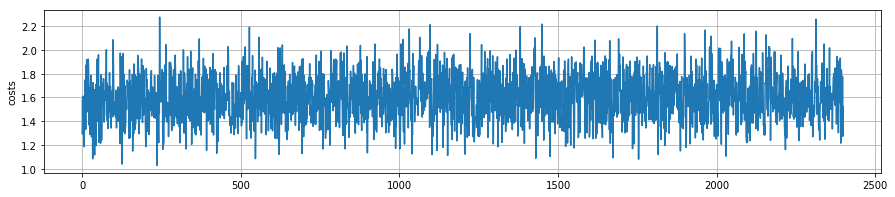

Target: <sos>關於萬國通路<eos> Return: <sos>本日粉絲憤怒<unk>house<eos>
Target: <sos>李安和特效公司的疑問<eos> Return: <sos>還有人在地下城黑洞嗎<eos>
Target: <sos>這個初音cosplay<unk><eos> Return: <sos>環太平洋的某個<sos><eos>
Target: <sos>各位能接受另一伴在fb分享男神女神動態嗎<eos> Return: <sos>關於威力的電影<eos>
Target: <sos>轉生<unk>渡各位會怎麼做<eos> Return: <sos>男生被服務的時候喜歡另一半什麼表現<eos>
Target: <sos>最新無薪假較<unk><unk><eos> Return: <sos>你能發現時期照片的問題嗎<eos>
Target: <sos>龍騎士07於推特透露新作將在2017年啟動<eos> Return: <sos>kirara這次限定答案嗎<eos>
Target: <sos>stb的時代將要結束<eos> Return: <sos>聽說是很多女孩初戀<eos>
Target: <sos>呼籲大家別再打手槍了<eos> Return: <sos>女孩們會在洗澡的時候尿尿嗎<eos>
Target: <sos>認識不長告白成功的關鍵是甚麼<eos> Return: <sos><unk>與克服<unk>某的各種語言要怎麼說<eos>
Elapsed time in epoch 11: 3554 [s]

epoch12
Iteration 240(9.96%); Train loss: 1.5622758556776053 (std: 0.19320751906504868); run time: 371[s]
Iteration 480(19.96%); Train loss: 1.5653002810519259 (std: 0.20272986688838773); run time: 749[s]
Iteration 720(29.96%); Train loss: 1.6184941127983745 (std: 0.2096137064867353); run time: 1133[s]
Iteration 9

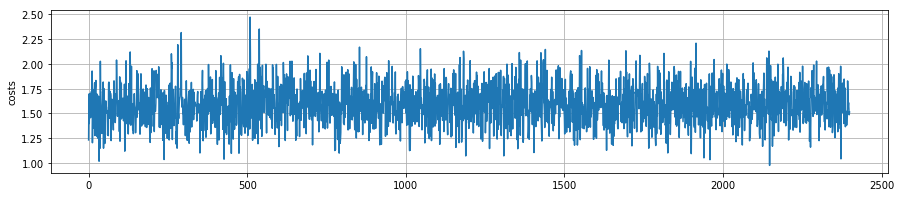

Target: <sos>消除朋友護照替代身分的電影<eos> Return: <sos>最後在稱讚找女伴的前輩有用嗎..<eos>
Target: <sos>電影對白公平vs<unk>的討論<eos> Return: <sos>32<unk><unk>女リ看看起來會<eos>
Target: <sos>mt<unk><eos> Return: <sos>你們黑重新進去戰<unk>的特效與過程<eos>
Target: <sos>常跟家人吵架<eos> Return: <sos><unk><sos>去哪裡了qq<eos>
Target: <sos>姉なるもの黑山羊姊姊25<unk>突破<eos> Return: <sos>台灣測驗文化<eos>
Target: <sos>怎樣算有大嬸味<eos> Return: <sos>有沒有人吸血鬼男女朋友卻一直失戀的<eos>
Target: <sos>有人跟健身女孩做過嗎<eos> Return: <sos><unk>吧上低音號06<eos>
Target: <sos>一部老國片<eos> Return: <sos>小小不起眼是不是....魔鬼<eos>
Target: <sos>有一段真摯的愛情擺在我眼前<eos> Return: <sos>半導體設備—外商研發缺<eos>
Target: <sos>分享一下失眠怎麼辦<eos> Return: <sos>交換禮物<eos>
Elapsed time in epoch 12: 3770 [s]

epoch13
Iteration 240(9.96%); Train loss: 1.5585806871189731 (std: 0.20594734302143988); run time: 377[s]
Iteration 480(19.96%); Train loss: 1.5672166763506634 (std: 0.19804986878979902); run time: 753[s]
Iteration 720(29.96%); Train loss: 1.561534050723932 (std: 0.19835081902602153); run time: 1133[s]
Iteration 960(39.96%); Train loss: 1.5809

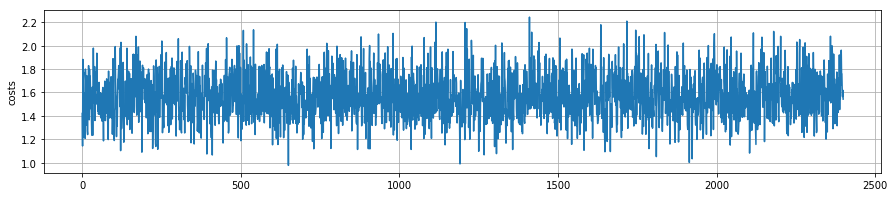

Target: <sos>板主自律條款<eos> Return: <sos>綿木gg電話怎麼辦<eos>
Target: <sos>line群組的人類行為<eos> Return: <sos>為什麼<unk>代表<eos>
Target: <sos>男友愛打手槍<eos> Return: <sos>把科幻程式興業<eos>
Target: <sos>有人有去過英國<unk>紅燈區嗎<eos> Return: <sos>gay得對新鮮人來說研替才是最好選擇<eos>
Target: <sos>東貝光電品管工程師<eos> Return: <sos>照片的自己和歧視中的自己長不一樣<eos>
Target: <sos><unk>辦法超越<unk>利亞嗎<eos> Return: <sos>如何判斷今晚有沒有搞頭<eos>
Target: <sos><unk>鼎奈米面試<eos> Return: <sos>聽到弟弟<unk>東西的過程<eos>
Target: <sos>一樣造型出現在不同作品的人<eos> Return: <sos>不暗示鄰居兒子的結婚紅包<eos>
Target: <sos>台灣男人到底平均幾公分阿<eos> Return: <sos>還有感情黑色機會嗎<eos>
Target: <sos>明天上映的一一<eos> Return: <sos>大家新人時期下班會原因多久才離開<eos>
Elapsed time in epoch 13: 3671 [s]

epoch14
Iteration 240(9.96%); Train loss: 1.5433235350772665 (std: 0.2045134919298587); run time: 350[s]
Iteration 480(19.96%); Train loss: 1.5477363747792947 (std: 0.18290583327800367); run time: 700[s]
Iteration 720(29.96%); Train loss: 1.5511005964535982 (std: 0.18136374226414684); run time: 1047[s]
Iteration 960(39.96%); Train loss: 1.55514975825119

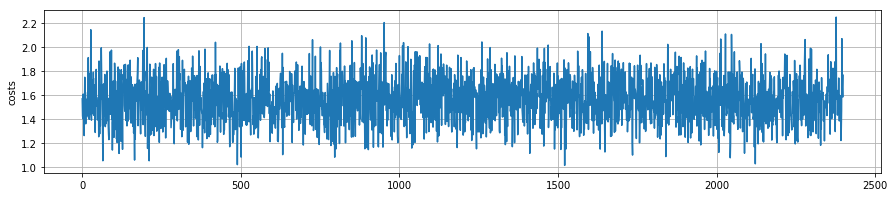

Target: <sos>つなこ老師<unk>生日賀圖<eos> Return: <sos>青春飯灰姑娘<eos>
Target: <sos>問一部假裝看得到幽靈的女人的老電影<eos> Return: <sos>追女生的心態<eos>
Target: <sos>凌巨科技<eos> Return: <sos>你們做過<unk>的事情是什麼<eos>
Target: <sos>關於人事<unk><eos> Return: <sos>睽違<unk><unk>口味<eos>
Target: <sos>tsmcrdpc<eos> Return: <sos>hero的賺錢是誰出的<eos>
Target: <sos>變形金剛<unk>最終騎士<unk>正式海報<eos> Return: <sos><unk>男子tv動畫化決定<eos>
Target: <sos>求推薦獨立樂團好聽的歌<eos> Return: <sos>在樂來看到的兩部片<eos>
Target: <sos>男友的家人<eos> Return: <sos>正妹好友單身工具了求解<sos><eos>
Target: <sos>漫威電影的觀看順序<eos> Return: <sos>有沒有喜歡的<sos>歌手半<eos>
Target: <sos>有遇過怪異的騎車姿勢嗎<eos> Return: <sos>姆咪是怎麼<unk>口味人氣半的<eos>
Elapsed time in epoch 14: 3490 [s]

epoch15
Iteration 240(9.96%); Train loss: 1.5413440696807257 (std: 0.18912565683694563); run time: 352[s]
Iteration 480(19.96%); Train loss: 1.5309779934122696 (std: 0.19740801813126724); run time: 703[s]
Iteration 720(29.96%); Train loss: 1.5442825259979256 (std: 0.18460490090729315); run time: 1045[s]
Iteration 960(39.96%); Train loss: 1.54803375785

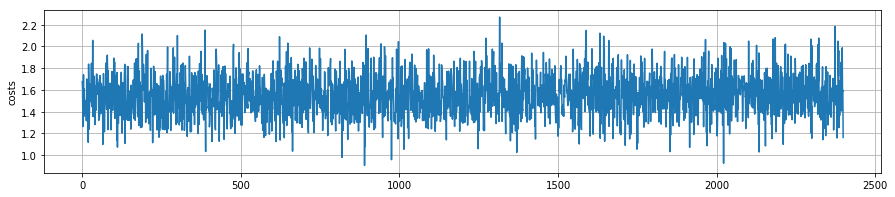

Target: <sos>ps4<unk>pc空戰奇兵7未知天際繁體中文版宣傳影片<eos> Return: <sos>工作時同事做什麼最讓你丟臉<eos>
Target: <sos>正妹不刮腋毛<eos> Return: <sos>男女之間的罵人<eos>
Target: <sos>勇者死於挖洞85無敵<eos> Return: <sos>怎樣才能還距離前男友<eos>
Target: <sos>正式切割<unk>怒<unk>以前不曾以<eos> Return: <sos>台北桃園新竹覺醒14的腳色公司<eos>
Target: <sos>喜歡去<unk>東西嗎<eos> Return: <sos>女生對於甜蜜的定義<eos>
Target: <sos>魔法使的新娘09預告<eos> Return: <sos>人的聲音是否<unk>就變真的<eos>
Target: <sos>該出席嗎<eos> Return: <sos>一部多年前的港片<eos>
Target: <sos>社會現象級的靈異事件<eos> Return: <sos>711必救<unk><eos>
Target: <sos>會有女生喜歡舔悶一天的肉棒嗎<eos> Return: <sos>廣達筆記本面試<eos>
Target: <sos>有沒有女生一個<unk>青年<unk>啊<eos> Return: <sos>離開gg的新人距離如何<eos>
Elapsed time in epoch 15: 3437 [s]

epoch16
Iteration 240(9.96%); Train loss: 1.51227850089861 (std: 0.19829532165752364); run time: 349[s]
Iteration 480(19.96%); Train loss: 1.5144553120774682 (std: 0.18632613384524593); run time: 701[s]
Iteration 720(29.96%); Train loss: 1.5532316106066 (std: 0.20465373689157793); run time: 1050[s]
Iteration 960(39.96%); Train loss: 1.547559764

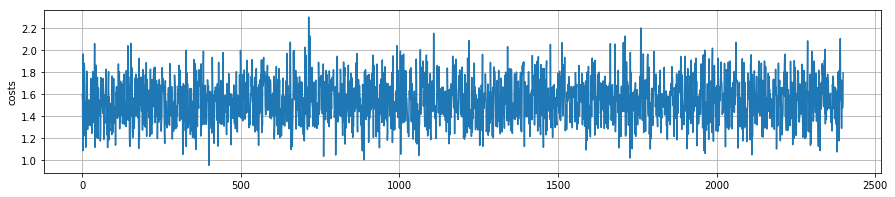

Target: <sos>五股佳能機構研替<eos> Return: <sos>求推薦降低又向的外套<eos>
Target: <sos>關於布魯斯威利<eos> Return: <sos>請問南科<unk>設備契約設備<eos>
Target: <sos><unk><unk>劇場板2之後<eos> Return: <sos>超好笑的西洋a片<eos>
Target: <sos>台灣人超愛戴口罩<eos> Return: <sos>這個オ有沒有搞頭<eos>
Target: <sos>轉生<unk><unk>的話要幹嘛<eos> Return: <sos>關於幹過<sos>的疑惑<eos>
Target: <sos>大家出門會看氣象嗎<eos> Return: <sos>有人有<sos>忘記專長經驗嗎<eos>
Target: <sos>活在當下<unk>未來<eos> Return: <sos>老人住在擁抱跟前怎麼辦<eos>
Target: <sos>安娜華特瘋狂假面走音天后<eos> Return: <sos><unk><sos>替<eos>
Target: <sos>市面上的<unk>持久<unk>是靠<unk>嗎<eos> Return: <sos>隔壁大會的妹子<eos>
Target: <sos>對朋友的佔有慾<eos> Return: <sos>男生會在意女生家長的顏色嗎<eos>
Elapsed time in epoch 16: 3446 [s]

epoch17
Iteration 240(9.96%); Train loss: 1.5005997957433588 (std: 0.19579044468862725); run time: 341[s]
Iteration 480(19.96%); Train loss: 1.495010696052408 (std: 0.19746799168980955); run time: 682[s]
Iteration 720(29.96%); Train loss: 1.513035404663222 (std: 0.19616606574827106); run time: 1024[s]
Iteration 960(39.96%); Train loss: 1.542880877290155

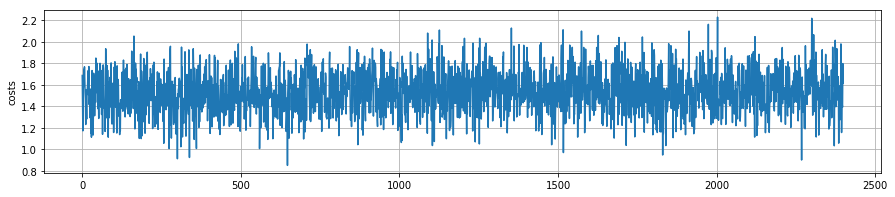

Target: <sos>會覺得叫室友起床是義務嗎<eos> Return: <sos>穩定的<unk>思考嗎<eos>
Target: <sos><unk>科技最近有在徵人<eos> Return: <sos>有人願意暗示轉科技追加<eos>
Target: <sos>怎麼跟女友玩迷姦<eos> Return: <sos>我在惠惠的賺錢心動<eos>
Target: <sos>女生國文都比較好<eos> Return: <sos>被皮膚的動畫片<eos>
Target: <sos>我的少女時代開場大真心的旁白<eos> Return: <sos>模犯生女孩是不是很不斷破處了<eos>
Target: <sos>分手不能乾脆些嗎<eos> Return: <sos>手機提供<unk>生日<eos>
Target: <sos>兩位槍法高超的人對決<eos> Return: <sos>asml按摩後硬起來<eos>
Target: <sos>真的有好色的女生嗎<eos> Return: <sos>女友跟我表達的想法<eos>
Target: <sos><unk>的製程工程師面試<eos> Return: <sos>英業達李依<eos>
Target: <sos>艾克爾amkor季獎金<eos> Return: <sos>有沒有ptt被想法罵<unk>的電影還是賣丟臉的<eos>
Elapsed time in epoch 17: 3422 [s]

epoch18
Iteration 240(9.96%); Train loss: 1.483243548983683 (std: 0.180946639976186); run time: 342[s]
Iteration 480(19.96%); Train loss: 1.5223364685886753 (std: 0.1925110629342745); run time: 680[s]
Iteration 720(29.96%); Train loss: 1.5293098105589176 (std: 0.19090565831128758); run time: 1021[s]
Iteration 960(39.96%); Train loss: 1.5387607262148653 (std: 0.1871

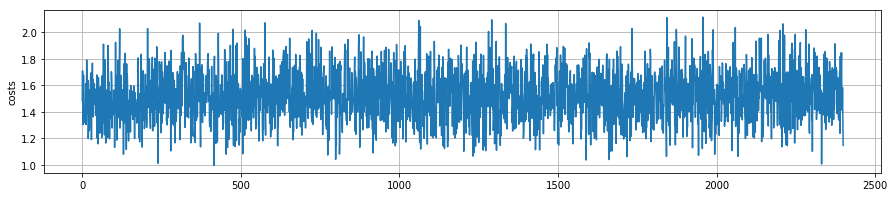

Target: <sos>不太算驚悚片但<unk>看的<unk><unk><eos> Return: <sos>關於臉書被電視<eos>
Target: <sos>モンスターストライクアニメ化決定<eos> Return: <sos>有人用過<unk>佈局床上運動嗎<eos>
Target: <sos>話說銀魂的<unk>理由嗎<eos> Return: <sos>acg中研發的人心<unk>哪些<eos>
Target: <sos>性愛能力最強的人種<eos> Return: <sos>大家可以接受開放結局嗎<eos>
Target: <sos>刺客教條第二波預告<eos> Return: <sos>女孩們會下介意嗎<eos>
Target: <sos>要怎麼分辨出工讀生<eos> Return: <sos>結婚的鬼片有雷<eos>
Target: <sos>有人遇過小<unk>系列的女主角嗎<eos> Return: <sos>fb上約聘動物的照片<eos>
Target: <sos>有女孩的學校也很盛行排球嗎<eos> Return: <sos>女版的變態是不是很多啊<eos>
Target: <sos>請問同事<unk>太重該怎麼辦<eos> Return: <sos>關於x戰警未來昔日裡的一首歌<eos>
Target: <sos>從小到大有被嘲笑過外表嗎<eos> Return: <sos>高捷2015本日最好笑<eos>
Elapsed time in epoch 18: 3418 [s]

epoch19
Iteration 240(9.96%); Train loss: 1.4876687238177666 (std: 0.16903606564038273); run time: 342[s]
Iteration 480(19.96%); Train loss: 1.4921155729214874 (std: 0.18677130187223565); run time: 684[s]
Iteration 720(29.96%); Train loss: 1.5190214945304823 (std: 0.20330529951216858); run time: 1026[s]
Iteration 960(39.96%); Train lo

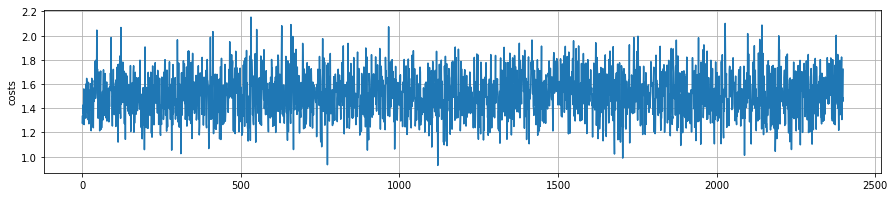

Target: <sos>關於頭<unk><eos> Return: <sos>猜高橋男角<eos>
Target: <sos>要怎麼讓小孩提升學習興趣<eos> Return: <sos>該轉職到設備票嗎<eos>
Target: <sos>有人吃過小7的<unk>麵線嗎<eos> Return: <sos>忍者龜跨<eos>
Target: <sos>寶可夢日月<unk><unk>聲優<unk><eos> Return: <sos>七龍珠戰爭中像聲優<sos>被<sos>也答應<eos>
Target: <sos><unk>司機被抓到的處罰<eos> Return: <sos>隔壁的講嗎<eos>
Target: <sos><unk>中有大蟑螂<eos> Return: <sos>r20デ變比較第一集嗎<eos>
Target: <sos>一部有關失去記憶的片<eos> Return: <sos>家裡被愛上<sos><sos><eos>
Target: <sos>有人吃魚喝茶被<unk>嗎<eos> Return: <sos>台南台中光電數位ic工程師<eos>
Target: <sos>家庭教師<unk><eos> Return: <sos>這是被打槍的意思嗎<eos>
Target: <sos>延後報到日期<eos> Return: <sos><unk>免役<eos>
Elapsed time in epoch 19: 3430 [s]

epoch20
Iteration 240(9.96%); Train loss: 1.475769853089662 (std: 0.17985235400876892); run time: 348[s]
Iteration 480(19.96%); Train loss: 1.486666376606462 (std: 0.19203903910115433); run time: 698[s]
Iteration 720(29.96%); Train loss: 1.5023026970808975 (std: 0.18986937085287803); run time: 1048[s]
Iteration 960(39.96%); Train loss: 1.4950228561313759 (std: 0.1

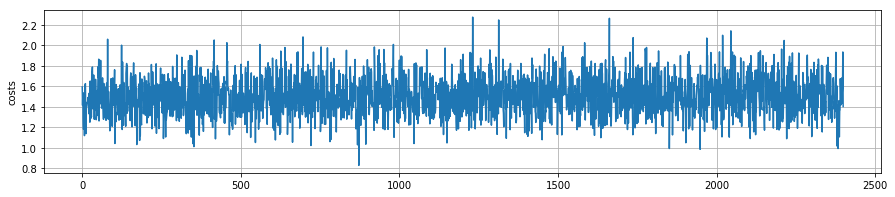

Target: <sos>朋友一直問什麼時候要離職<eos> Return: <sos>如何才能不勃起<eos>
Target: <sos>國王該如何處理和勇者的關係<eos> Return: <sos>求神人好感這是<unk>的<eos>
Target: <sos>謝謝撿到我手機的好心人<eos> Return: <sos>娶<unk>什麼<sos>呢<eos>
Target: <sos>集結各路高手的電影<eos> Return: <sos>假如到底是什麼<eos>
Target: <sos>坎城影展台北工廠預告片<eos> Return: <sos>關於中科院和有前景的小公司<eos>
Target: <sos>有關離職公司書面文件處理<eos> Return: <sos>肛交真的是可以單獨的嗎<eos>
Target: <sos>朋友喜歡跑按摩店怎麼辦<eos> Return: <sos>女孩們告訴另一半自己pttid嗎<eos>
Target: <sos><unk>科技<eos> Return: <sos>員工<unk>分顏色的本人<eos>
Target: <sos>jojo動畫要怎麼補比較好<eos> Return: <sos>連續這件胸連續第二支電影票活動<eos>
Target: <sos>會捐腎給好朋友嗎<eos> Return: <sos>埋梗金錢<sos>的片<eos>
Elapsed time in epoch 20: 3506 [s]

Elapsed time in total: 69409


In [10]:
import time
import random
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.contrib import layers
import matplotlib
import matplotlib.pyplot as plt
################################################################
# Set parameter
################################################################
# batch parameter
build_new_model = True
patience = 0
num_epoch = 20
batch_size = 32
num_instances = len(y_train)
iter_per_epoch = num_instances // batch_size
test_num_instances = len(y_test)
test_iter_per_epoch = test_num_instances // batch_size
test_number = 10

# seq2seq parameter
limit_generation_len = max_title_length
embed_units_size = 300
rnn_size = 300
num_layers = 1
beam_width = 10

# regularization parameter
lstm_dropout = 0.5
l2_reg_const = 0.001

# optimization parameter
exp_decay_rate = 0.8
lr = 0.0001
clip_const = 0.1

# helper parameter
only_train_helper = True
cos_decay_steps = num_epoch * 1 // 10 * iter_per_epoch
decoder_start_step = num_epoch * 1 // 10 * iter_per_epoch
decoder_end_step = num_epoch * 8 // 10 * iter_per_epoch

################################################################
# Load Embedding model
################################################################
def load_embed():
    embed_epoch = 40
    embed_name = 'PTT_Words_Embedding_1523903534.3398497'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    embed_dir = os.path.join(mdl_dir, embed_name)
    if not os.path.exists(embed_dir):
        os.makedirs(embed_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_embed_dir = os.path.join(embed_dir, 'model-{}'.format(embed_epoch))
        loader = tf.train.import_meta_graph(load_embed_dir + '.meta')
        loader.restore(sess, load_embed_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
        print('Embeddings lookup shape: ', embeddings.shape)
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
    return embeddings, normal_embeddings

################################################################
# Build seq2seq model
################################################################
def model_input():
    ######## model input tensor ########
    is_training = tf.placeholder(tf.bool, (), name='is_training')
    is_decoder_in = tf.placeholder(tf.bool, (), name='is_decoder_in')
    is_time_major = tf.placeholder(tf.bool, (), name='is_time_major')
    inputs = tf.placeholder(tf.int32, (None, None), name='inputs')
    targets = tf.placeholder(tf.int32, (None, None), name='targets')
    input_seq_len = tf.placeholder(tf.int32, (None,), name='input_seq_len')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    limit_target_seq_len = tf.placeholder(tf.int32, (), name='limit_target_seq_len')
    input_batch_size = tf.shape(inputs)[0]
    return is_training, is_decoder_in, is_time_major, inputs, targets, input_seq_len, target_seq_len, limit_target_seq_len, input_batch_size
    
# LSTM cell
def get_rnn_cell(is_training, rnn_size, layer):
    rnn_cell = tf.contrib.rnn.LSTMCell(rnn_size, 
                initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
                #initializer=tf.random_uniform_initializer(-1.0, 1.0, dtype=tf.float64))
    #rnn_cell = tf.contrib.rnn.GRUCell(rnn_size, 
                                      #kernel_initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
    if is_training is not None and lstm_dropout < 1.0:
        if layer == 0:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      input_keep_prob=lstm_dropout, 
                                                      output_keep_prob=lstm_dropout)
        else:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      output_keep_prob=lstm_dropout)
    return rnn_cell
    
def embeddings_layer():
    ######## Build embedding layer weight. ########
    #embeddings = tf.constant(load_embed()[0], dtype=tf.float64)
    embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embed_units_size], -1.0, 1.0, 
                                               dtype=tf.float64),name='embeddings')
    return embeddings

def encoder_layer(is_training, is_time_major, 
                inputs, input_seq_len, embeddings):
    ######## Build encoder layer weight. ########
    if is_time_major is not None:
        inputs = tf.transpose(inputs, [1, 0])
        time_major_bool = True
    else:
        time_major_bool = False
    encoder_embed_input = tf.nn.embedding_lookup(embeddings, inputs)
    
    # Struct encoder by LSTM multi-layer
    '''encoder_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell, 
                                                       encoder_embed_input, 
                                                       sequence_length=input_seq_len, 
                                                       dtype=tf.float64, 
                                                       time_major=time_major_bool)
    '''
    # Struct encoder by LSTM bi-directional multi-layer
    encoder_f_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_b_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(encoder_f_cell, 
                                                                           encoder_b_cell, 
                                                                           encoder_embed_input, 
                                                                           sequence_length=input_seq_len, 
                                                                           dtype=tf.float64, 
                                                                           time_major=time_major_bool)
    encoder_outputs = tf.concat((encoder_bi_outputs[0], encoder_bi_outputs[1]), 2)
    #encoder_state = tf.concat((encoder_bi_state[0], encoder_bi_state[1]), 2)
    encoder_state = tuple([tf.contrib.rnn.LSTMStateTuple(tf.concat((state_f.c, state_b.c), 1), 
                                                          tf.concat((state_f.h, state_b.h), 1))
                     for state_f, state_b in zip(encoder_bi_state[0], encoder_bi_state[1])])
    
    return encoder_outputs, encoder_state

def attention_layer(is_training, is_time_major, 
                    encoder_outputs, encoder_state, 
                    input_seq_len, input_batch_size):
    ######## Build attention layer weight. ########
    if is_time_major is not None:
        encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])
    
    # Struct LSTM cell in Decoder
    multi_rnn_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size*2, layer)
                                                for layer in range(num_layers)])
    
    '''# For beam search decoder
    encoder_outputs = tf.contrib.seq2seq.tile_batch(
        encoder_outputs, multiplier=beam_width)
    input_seq_len = tf.contrib.seq2seq.tile_batch(
        input_seq_len, multiplier=beam_width)
    encoder_state = tf.contrib.seq2seq.tile_batch(
        encoder_state, multiplier=beam_width)
    input_batch_size = input_batch_size * beam_width
    '''
    #attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size*2, encoder_outputs,
    attention_mechanism = tf.contrib.seq2seq.LuongAttention(rnn_size*2, encoder_outputs,
                                                            memory_sequence_length=input_seq_len,
                                                            dtype=tf.float64)
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(multi_rnn_cell, 
                                                       attention_mechanism, 
                                                       attention_layer_size=rnn_size)
    decoder_ini_state = decoder_cell.zero_state(input_batch_size,
                                                tf.float64).clone(cell_state=encoder_state)
    return decoder_ini_state, decoder_cell

'''def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, limit_target_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                           [input_batch_size * beam_width], name='start_tokens')
    # Define a beam-search decoder
    rnn_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
        cell=decoder_cell,
        embedding=embeddings,
        start_tokens=start_tokens,
        end_token=vocab[EOS_id],
        initial_state=decoder_initial_state,
        beam_width=beam_width,
        projection_layer=projection_layer,
        length_penalty_weight=0.0)
    
    decoder_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        rnn_decoder, impute_finished=True, maximum_iterations=limit_target_seq_len)
    
    translations = outputs.predicted_ids
    # Make sure translations shape is [batch_size, beam_width, time]
    if is_time_major is not None:
        translations = tf.transpose(translations, perm=[1, 2, 0])

    ######## Model output tensor ########
    training_logits = tf.identity(decoder_output.rnn_output, name='training_logits')
    training_ids = tf.identity(decoder_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len'''

def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, limit_target_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    ######## Build decoder layer weight. ########
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    if is_decoder_in is not None:
        if is_time_major is not None:
            targets = tf.transpose(targets, [1, 0])
        decoder_embed_input = tf.nn.embedding_lookup(embeddings, targets)
        training_helper = tf.contrib.seq2seq.TrainingHelper(
            decoder_embed_input, target_seq_len, time_major=time_major_bool)
    else:
        start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                               [input_batch_size], name='start_tokens')
        training_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embeddings, start_tokens, vocab[EOS_id])

    training_decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, training_helper, decoder_ini_state, projection_layer) 
    training_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        training_decoder, impute_finished=True, maximum_iterations=limit_target_seq_len)
    
    ######## Model output tensor ########
    training_logits = tf.identity(training_output.rnn_output, name='training_logits')
    training_ids = tf.identity(training_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len
    
def loss_function(training_logits, targets, target_seq_len, max_seq_len):
    ######## Build loss function ########
    masks = tf.sequence_mask(target_seq_len, max_seq_len, dtype=tf.float64)
    cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks, name='sequence_cost')
    return cost
    
def optimization(cost):
    ######## Build optimization ########
    # Add regularization to Loss
    lossL2 = tf.Variable(0.0, trainable=False, dtype=tf.float64)
    #regularization_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    lossL2 = l2_reg_const * sum( tf.nn.l2_loss(var)
                                for var in tf.trainable_variables() if not ('Bias' in var.name))
    
    # Optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        lr, global_step, iter_per_epoch, exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-12)
    
    # Gradient Clipping
    gradients, vriables = zip(*optimizer.compute_gradients(cost+lossL2))
    gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_const)
                 for gradient in gradients]
    train_step = optimizer.apply_gradients(zip(gradients, vriables), name='train_step')
    return train_step

################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    decoder_global_step = 0
    model_name = 'PTT_Encoder-Decoder_model_fixed_' + str(total_start_t)
else:
    str_epoch = 1
    decoder_global_step = str_epoch * iter_per_epoch
    model_name = 'PTT_Encoder-Decoder_model_fixed_1524077398.2482338'

mdl_dir = os.path.join(base_dir, 'model')
model_dir = os.path.join(mdl_dir, model_name)
                    
iter_pct10 = iter_per_epoch // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
batch_cutoff = [0]
for i in range(iter_per_epoch - 1):
    batch_cutoff.append(batch_size * (i+1))
batch_cutoff.append(num_instances)
costs_list = []

best_costs_mean = 0.0
early_stop_counter = 0
last_loss = 0.0
last_rnn_output = 0.0
last_train_op = 0.0
################################################################
# Run model session
################################################################
train_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with train_graph.as_default():
        # Build input parameters
        is_training, is_decoder_in, is_time_major, inputs, targets, input_seq_len, target_seq_len, limit_target_seq_len, input_batch_size = model_input()
        # Build model and weight parameters
        embeddings = embeddings_layer()
        encoder_outputs, encoder_state = encoder_layer(
            is_training, is_time_major,
            inputs, input_seq_len, embeddings)
        decoder_ini_state, decoder_cell = attention_layer(
            is_training, is_time_major, 
            encoder_outputs, encoder_state, 
            input_seq_len, input_batch_size)
        training_logits, training_ids, training_seq_len = decoder_layer(
            is_training, is_decoder_in, is_time_major, 
            targets, target_seq_len, limit_target_seq_len, 
            decoder_ini_state, decoder_cell, 
            input_batch_size, embeddings)
        # Build optimizer
        cost = loss_function(training_logits, targets, target_seq_len, training_seq_len)
        train_step = optimization(cost)

with tf.Session(graph=train_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        is_training = train_graph.get_tensor_by_name('is_training:0')
        is_decoder_in = train_graph.get_tensor_by_name('is_decoder_in:0')
        is_time_major = train_graph.get_tensor_by_name('is_time_major:0')
        inputs = train_graph.get_tensor_by_name('inputs:0')
        targets = train_graph.get_tensor_by_name('targets:0')
        input_seq_len = train_graph.get_tensor_by_name('input_seq_len:0')
        target_seq_len = train_graph.get_tensor_by_name('target_seq_len:0')
        limit_target_seq_len = train_graph.get_tensor_by_name('limit_target_seq_len:0')
        # Load named output and optimizer parameters
        predicting_ids = train_graph.get_tensor_by_name('predicting_ids:0')
        training_logits = train_graph.get_tensor_by_name('training_logits:0')
        training_ids = train_graph.get_tensor_by_name('training_ids:0')
        cost = train_graph.get_tensor_by_name('sequence_cost/truediv:0')
        train_step = train_graph.get_operation_by_name('train_step')
    
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        costs = []
        
        ######## Get random input batch and training model. ########
        for i in range(iter_per_epoch):
            X_batch = []
            Y_batch = []
            X_size = []
            Y_size = []
            for n in range(batch_cutoff[i],batch_cutoff[i+1]):
                X_batch.append(x_train[rand_idxs[n]])
                Y_batch.append(y_train[rand_idxs[n]])
                X_size.append(x_train_size[rand_idxs[n]])
                Y_size.append(y_train_size[rand_idxs[n]])
            X_size_max = max(X_size)
            Y_size_max = max(Y_size)
            X_batch = np.array(X_batch)
            Y_batch = np.array(Y_batch)
            X_size = np.array(X_size)
            Y_size = np.array(Y_size)
            
            # Select helper based on learning time.
            '''decoder_random = np.random.uniform(0.0, 1.0)
            decoder_global_step = min(decoder_global_step, decoder_end_step)
            decoder_step = max(decoder_global_step - decoder_start_step, 0)
            helper_rate = 0.5 * (1.0 + np.cos(np.pi * decoder_step / (decoder_end_step - decoder_start_step)))
            '''
            decoder_global_step +=1
            #if decoder_random<helper_rate or only_train_helper:
            feed_dict = {is_training: True, is_decoder_in: True, is_time_major: True,
                 inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                 input_seq_len: X_size, target_seq_len: Y_size,
                 limit_target_seq_len: limit_generation_len}
            '''else:
                feed_dict = {is_training: True, is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}'''
            
            if (i + 1) % iter_pct10 == 0:
                train_op, loss, output_ids = sess.run(
                    [train_step, cost, training_ids], feed_dict)
            else:
                train_op, loss = sess.run(
                    [train_step, cost], feed_dict)
            
            if np.isnan(loss):
                print('\n!!!! Loss is NaN! !!!!')
                print('NaN epoch: ', e, ' ; NaN iteration: ', i+1)
                print('Stop decoder_global_step: ', decoder_global_step)
                print('The last loss: ', last_loss)
                break
            else:
                costs.append(loss)
                last_loss = loss
            
            if (i + 1) % iter_pct10 == 0:
                if e==0:
                    if not os.path.exists(mdl_dir):
                        os.makedirs(mdl_dir)
                    if not os.path.exists(model_dir):
                        os.makedirs(model_dir)
                
                costs_pct10 = np.array(costs[-iter_pct10:])
                log = 'Iteration {}({}%); Train loss: {} (std: {}); run time: {}[s]'.format(
                    str(i+1), str(round(i*100/iter_per_epoch,2)),
                    str(costs_pct10.mean()), str(costs_pct10.std()),
                    str(int(time.time() - start_t)))
                print(log)
                log += '\n'
                for batch_index in range(batch_size):
                    log += 'Target: {}'.format("".join([vocab_reverse[i] for i in Y_batch[batch_index] if i != 0]))
                    log += '; Return: {}'.format("".join([vocab_reverse[i] for i in output_ids[batch_index] if i != 0]))
                    log += '\n'
                else:
                    with open(os.path.join(model_dir, 'Target_Return.txt'),
                            'a', encoding = 'utf-8-sig') as file:
                        file.write('Epoch' + str(e+1) + '\n' + log + '\n')
        
        ######## Save model weight parameters and information. ########
        costs_mean = np.array(costs).mean()
        print('Train Loss: ', costs_mean)
        if costs_mean < best_costs_mean or e == 0:
            best_costs_mean = costs_mean
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! '+str(best_costs_mean))
        else:
            early_stop_counter += 1
            print('Count early stop!! '+str(early_stop_counter))
        
        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        ######## Print cost curve of this epoch. ########
        costs_list.append(costs)
        plt.figure(figsize=(15,3))
        plt.plot(costs)
        plt.ylabel('costs')
        plt.grid()
        plt.show()
        
        ######## Generate title form testing content and validating model. ########
        Xt_batch = []
        Yt_batch = []
        Xt_size = []

        for _ in range(test_number):
            n = random.randint(0, test_num_instances-1)
            Xt_batch.append(x_test[n])
            Yt_batch.append(y_test[n])
            Xt_size.append(x_test_size[n])
        Xt_size_max = max(Xt_size)
        Xt_batch = np.array(Xt_batch)
        Yt_batch = np.array(Yt_batch)
        Xt_size = np.array(Xt_size)
            
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)
        for n in range(test_number):
            log = 'Target: {}'.format("".join([vocab_reverse[i] for i in Yt_batch[n] if i != 0]))
            print(log + ' Return: {}'.format("".join([vocab_reverse[i] for i in answer_ids[n] if i != 0])))
        
        print('Elapsed time in epoch ' + str(e+1) + ': ' + str(int(time.time() - start_t)) + ' [s]')
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_costs_mean, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

In [11]:
import os
import random
################################
#Generate title form testing content and validating model. 
################################
base_dir = 'C:/Users/User/Raw data/PTT'
model_name = 'PTT_Encoder-Decoder_model_fixed_1524336939.7360933'
epoch = 12
model_path = os.path.join(base_dir, 'model', model_name, 'model-{}'.format(epoch))
print('Test epoch: ', epoch)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)
    # Named parameters
    #is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_decoder_in = loaded_graph.get_tensor_by_name('is_decoder_in:0')
    is_time_major = loaded_graph.get_tensor_by_name('is_time_major:0')
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    input_seq_len = loaded_graph.get_tensor_by_name('input_seq_len:0')
    target_seq_len = loaded_graph.get_tensor_by_name('target_seq_len:0')
    limit_target_seq_len = loaded_graph.get_tensor_by_name('limit_target_seq_len:0')
    # Load named output and optimizer parameters
    training_logits = loaded_graph.get_tensor_by_name('training_logits:0')
    training_ids = loaded_graph.get_tensor_by_name('training_ids:0')
    cost = loaded_graph.get_tensor_by_name('sequence_cost/truediv:0')
    train_step = loaded_graph.get_operation_by_name('train_step')
    
    for _ in range(10):
        i_str = random.randint(0,test_num_instances-1)
        i_end = i_str + 1

        X_batch = np.tile(x_test[i_str], (batch_size, 1))
        Y_batch = np.tile(y_test[i_str], (batch_size, 1))
        X_size = np.tile(x_test_size[i_str], (batch_size))
        Y_size = np.tile(y_test_size[i_str], (batch_size))
        max_X_size = x_test_size[i_str]
        max_Y_size = y_test_size[i_str]
        '''answer_ids = sess.run( logits, {inputs: X_batch, targets: Y_batch, 
                                             input_seq_len: X_size, target_seq_len: Y_size,
                                             limit_target_seq_len: limit_generation_len})'''
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)

        output_index = 0 #random.randint(0,batch_size-1)
        print('\n========')
        print('Test index: ', i_str + output_index)
        print('========')
        print('Test input Words: {}'.format("".join([vocab_reverse[i] for i in X_batch[output_index] if i != 0])))
        print('Target Words: {}'.format("".join([vocab_reverse[i] for i in Y_batch[output_index] if i != 0])))
        print('Response Words: {}'.format("".join([vocab_reverse[i] for i in answer_ids[output_index] if i != 0])))

Test epoch:  12
INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_Encoder-Decoder_model_fixed_1524336939.7360933\model-12

Test index:  12953
Test input Words: <sos>姜文以一部讓子彈飛站著在中國市場把錢<unk>了可幾年過去如今中國市場的轉變又跟當時不一樣了看看現在<unk>表態的可怕風氣不僅外國人就連中國人都要一一表達<unk>才能在中國<unk>更不用<unk>人了幾乎成了跪著<unk>的如今大陸的電影市場還有誰能像姜文一樣站著把錢<unk>了或者這一部也是特例<unk>一部<unk>多麼慘不忍睹sentfromjpttonmyiphone<eos>
Target Words: <sos>除了姜文誰<unk>著把錢<unk>了<eos>
Response Words: <sos>除了川普誰<unk>著把錢<unk>了<eos>

Test index:  10685
Test input Words: <sos>會問這樣的問題其實是因為家人非常喜歡現任女友是那種一分手家人都會責怪我的那種喜歡抱歉有點<unk>不過我真的不知道怎麼形容比較恰當言歸正傳日前分手了不知該如何向家人坦承這幾天女友沒來我們家裡我媽就會問誒你女朋友怎麼<unk><unk>沒來所以想請教各位先輩該如何面對和解決這樣的困境<eos>
Target Words: <sos>nan<eos>
Response Words: <sos>nan<eos>

Test index:  4987
Test input Words: <sos>其實我看到動畫一集我就不想看了就是台上有五位評審在<unk>作品的時後有三位評審在吵架有兩位評審看起來是路人然後那兩位評審要提供意見那三位其中一個人講路人甲乙閉嘴然後那兩位就真的閉嘴了要是評審都是路人甲乙都能參加而且評審連評審的自尊都沒有你就知道這種比賽根本不重要那時後我就看不下去了<eos>
Target Words: <sos>食戟之靈怎麼可以變那摸難看<eos>
Response Words: <sos>食戟之靈怎麼可以變那摸難看<eos>

T